In [1]:
import numpy as np
import pylab as plt
import os

from functions import *
from line_cross_standard_utilities import *
from line_cross_tensorflow_prediction_utilities import *

plt.rc('image', cmap='plasma') 

In [2]:
def accuracy(gt, pred, mask):

    gap_true = gt*mask
    gap_pred = pred*mask
    
    acc = (1 - np.sum(np.abs(gap_true-gap_pred))/np.sum(gap_true))*100
    if acc<0:
        acc = 0
    
    return acc

# Load one data

In [3]:
path = 'path_of_the_BCDI_with_gap'


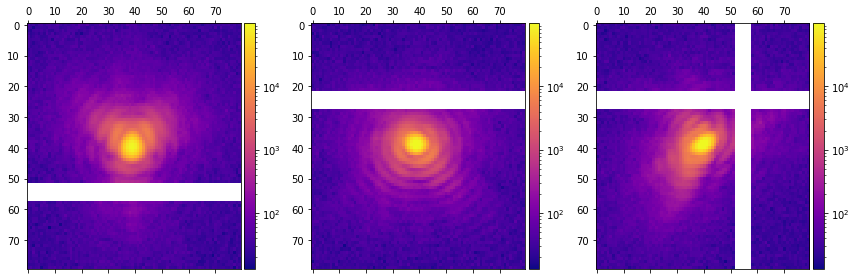

In [170]:
data_masked_linear = np.load(path)
plot_3D_projections(data_masked_linear, log_scale = True)

# Data pre-processing

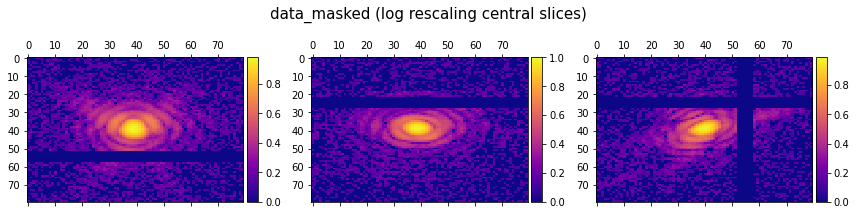

In [171]:
data_masked, maxi_rescale1, maxi_rescale2 = data_preprocessing(data_masked_linear)
plot_central_slices(data_masked, fig_title='data_masked (log rescaling central slices)')

# Find gap parameters automatically

In [172]:
gap_params = find_gap_parameters(mask, verbose=True)

gap_shape : cross
axis_parallel : 2
gap_size : 6
mask_position : [24. 54. nan]
pixel_masked : [array([22, 23, 24, 25, 26, 27]) array([52, 53, 54, 55, 56, 57]) list([])]


# Load corresponding gap size model

In [198]:
from tensorflow.keras import losses
keras.losses.custom_loss = MyLoss_noisy

model_path = 'model_path'
print('model path :', model_path)
keras.losses.custom_loss = MyLoss_noisy

if os.path.exists(model_path):
    print('This gap size model exists')
    import tensorflow as tf 
    print(tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    model = tf.keras.models.load_model(model_path, custom_objects=None, compile=False)
    print('Models loading done.')
else:
    print('Error, this gap size model doesn\'t exits yet')

model path : /data/projects/id01ml/SavedModels/3D_inpainting_portions32_6px_cross/
This gap size model exists
2.2.0
Num GPUs Available:  1
Models loading done.


In [197]:
skip_pixels = 0
prediction = gap_prediction(data_masked, mask, gap_params, model,
                   skip_pixels=skip_pixels)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 48 48 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 48 48 

# Make the postprocessing

In [207]:
prediction_linear = post_processing_prediction(prediction, maxi_rescale1, maxi_rescale2)
